# Some preliminary python code

In [1]:
%matplotlib inline

import warnings; warnings.simplefilter('ignore')

import matplotlib.pyplot as plt
import numpy as np
import sklearn

# Univariate continuous -> continuous filter: Boston housing regression dataset

As an example, we will consider the boston housing prices dataset. This regression dataset has 13 continuous (real, positive) features with 506 samples. 

In [1]:
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline

from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import f_regression

from sklearn.pipeline import make_pipeline
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler

data  = load_boston()

data_to_keep = data['target'] < 45
data['data'] = data['data'][data_to_keep]
data['target'] = data['target'][data_to_keep]

# We split the dataset with 15% as a test, using stratified to ensure the train and test sets
# both have approximately the same statistics as the whole dataset
X_train, X_test, y_train, y_test = train_test_split(data['data'], data['target'], test_size=0.15)

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


/home/mraillat/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np

        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dat

In [3]:
print(X_train.shape)

(411, 13)


## Baseline without feature selection

**Without** feature selection, we use all the 13 features for the RBF SVR

RMSE on the test set : 2.99


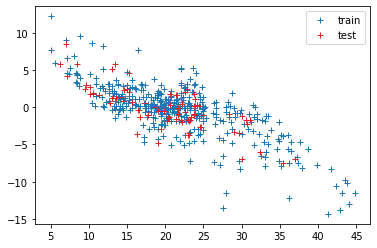

Real risk by cross validation: 4.77


In [3]:
# Train the classification SVR
clf = SVR(kernel='rbf')
clf.fit(X_train, y_train) 

# Finally, we estimate the MSE on the test set
y_test_pred = clf.predict(X_test)
rmse = np.sqrt(((y_test - y_test_pred)**2).mean())
print("RMSE on the test set : {:.2f}".format(rmse))

plt.figure()
plt.plot(y_train, clf.predict(X_train)-y_train,'+', color='tab:blue', label='train')
plt.plot(y_test, clf.predict(X_test)-y_test,'+', color='tab:red', label='test')
plt.legend()
plt.show()

# We can also estimate the real risk by cross validating the whole process
clf = make_pipeline(StandardScaler(), 
                    SVR(kernel='rbf'))
scores = -cross_val_score(clf, data['data'], data['target'],
                         scoring='neg_mean_squared_error', cv=10)
print("Real risk by cross validation: %0.2f" % (np.sqrt(scores.mean())))


## Compute the correlation coefficients

In [4]:
# Compute the F-valuues
f_values = f_regression(X_train, y_train)[0]

print(f_values)

# Sort the F-values
sorted_idx = np.argsort(f_values)

highest_F_idx = sorted_idx[-1]
lowest_F_idx = sorted_idx[0]




[111.36572934  67.7989002  217.59518205   1.43958862 148.85221651
 274.93314732 124.37377901  56.6484829  123.44694849 186.08849548
 139.39598191  79.21038333 538.88541863]


## Feature selection

**With** feature selection, where 3 of the features which have the highest F are selected. In this selection, denoting X the considered feature and y the continuous target, we select the features which are the most correlated with the target.

In [5]:
# We perform feature selection from the training set
selector = SelectKBest(f_regression, k=3)
selector.fit(X_train, y_train)

# Print out which are the selected features
selected_indices = selector.get_support(indices=True)
names_selected_indices = [data['feature_names'][i] for i in selected_indices]
print("The selector selected {} features, which have the indices {}, i.e. {}".format(len(selected_indices), selected_indices, names_selected_indices))

# We reduce the training set 
X_train_red = selector.transform(X_train)

# Train the regression SVM
clf = SVR(kernel='rbf')
clf.fit(X_train_red, y_train) 

# Finally, we estimate the accuracy on the test set
y_test_pred = clf.predict(selector.transform(X_test))
rmse = np.sqrt(((y_test - y_test_pred)**2).mean())
print("RMSE on the test set : {:.2f}".format(rmse))

# We can also estimate the real risk by cross validating the whole process
clf = make_pipeline(StandardScaler(), 
                    SelectKBest(f_regression, k=3),
                    SVR(kernel='rbf'))
scores = -cross_val_score(clf, data['data'], data['target'],
                         scoring='neg_mean_squared_error', cv=10)
print("Real risk by cross validation: %0.2f" % (np.sqrt(scores.mean())))


The selector selected 3 features, which have the indices [ 2  5 12], i.e. ['INDUS', 'RM', 'LSTAT']
RMSE on the test set : 3.03
Real risk by cross validation: 4.10
